# Import 

In [131]:
import jsonlines
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy.spatial.distance import cosine
from scipy.special import rel_entr as entropy
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import torch

import seaborn as sns
from textstat import flesch_reading_ease
import jsonlines 
from transformers import BertTokenizer, BertModel


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
sentence_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



[nltk_data] Downloading package punkt to /Users/jashkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jashkina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jashkina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. i

# Make Features

In [135]:
def extract_ideas(text):
    text = text.lower()
    ideas = []
    
    lines = text.split("\n")
    for line in lines:
        line = line.strip()
        
        if re.match(r'\d+\.', line):
            idea = re.sub(r'\d+\.', '', line).strip()
            ideas.append(idea)
        
        elif re.match(r'-', line):
            idea = re.sub(r'-', '', line).strip()
            ideas.append(idea)
        
        else:
            ideas.append(line)

    ideas = list(set([idea for idea in ideas if idea]))
    
    return ideas

def load_results(file_path):
    with jsonlines.open(file_path, mode='r') as reader:
        data = [row for row in reader]
    return pd.DataFrame(data)

def bert_embedding(texts, model, tokenizer):
    embeddings_list = []
    for text in texts:
        tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**tokens)
        
        embeddings = outputs.last_hidden_state
        mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.shape).float()
        masked_embeddings = embeddings * mask
        summed = torch.sum(masked_embeddings, 1)
        lengths = torch.sum(mask, 1)
        average_embeddings = summed / lengths
        embeddings_list.append(average_embeddings.squeeze().numpy())
    return embeddings_list


def semantic_embedding(texts, model):
    embeddings_list = []
    for text in texts:
        idea_embeddings = model.encode(text)
        embeddings_list.append(idea_embeddings)
    return embeddings_list

def pos_distributions(texts):
    pos_dists = []
    for text in texts:
        tokens = word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        pos_counts = Counter(tag for word, tag in pos_tags)
        total_tags = sum(pos_counts.values())
        pos_dist = {tag: count / total_tags for tag, count in pos_counts.items()}
        pos_dists.append(pos_dist)
    return pos_dists

def average_length(texts):
    return np.mean([len(text.split()) for text in texts])

def average_readability(texts):
    return np.mean([flesch_reading_ease(text) for text in texts])

def cosineb_distances2(row):
    distances = []
    outputs = np.mean(row['output_bert_embeddings'],axis=1)
    examples = np.mean(row['example_bert_embeddings'],axis=1)
    distance = cosine(list(outputs),list(examples))
    return distance


def cosineb_distances(row):
    distances = []
    outputs = row['output_bert_embeddings']
    examples = row['example_bert_embeddings']
    distances = []
    for o_embedding in outputs:
        for e_embedding in examples:
            distance = cosine(list(o_embedding),list(e_embedding))
            distances.append(distance)
    return np.mean(distances)


def cosine_distances2(row):
    distances = []
    outputs = np.mean(row['output_embeddings'],axis=1)
    examples = np.mean(row['example_embeddings'],axis=1)
    distance = cosine(list(outputs),list(examples))
    return distance


def cosine_distances(row):
    distances = []
    outputs = row['output_embeddings']
    examples = row['example_embeddings']
    distances = []
    for o_embedding in outputs:
        for e_embedding in examples:
            distance = cosine(list(o_embedding),list(e_embedding))
            distances.append(distance)
    return np.mean(distances)

def pos_distances(row):
    pd1 = row['output_pos_dists']
    pd2 = row['example_pos_dists']
    intersecting_tags = set(pd1.keys()) & set(pd2.keys())
    distance = sum(abs(pd1[tag] - pd2[tag]) for tag in intersecting_tags)
    return distance

def length_distances(row):
    l1 = np.mean([len(x) for x in row['output']])
    l2 = np.mean([len(x) for x in row['examples']])
    return l2-l1

def readability_distances(row):
    l1 = np.mean([flesch_reading_ease(x) for x in row['output']])
    l2 = np.mean([flesch_reading_ease(x) for x in row['examples']])
    return l2-l1




                                                   
                                                   
res = load_results("results_2023-04-01-15-56-20.jsonl")

res['output'] = res['output_responses'].apply(lambda x: extract_ideas(x))

# Semantic embeddings
#sentence_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
res['output_embeddings'] = semantic_embedding(res['output'], sentence_model)
res['example_embeddings'] = semantic_embedding(res['examples'], sentence_model)

res['output_bert_embeddings'] = bert_embedding(res['output'], bert_model, bert_tokenizer)
res['example_bert_embeddings'] = bert_embedding(res['examples'], bert_model, bert_tokenizer)

# Compute POS distributions
res['output_pos_dists'] = pos_distributions(res['output'].apply(' '.join))
res['example_pos_dists'] = pos_distributions(res['examples'].apply(' '.join))

# Compute length and readability
res['output_length'] = res['output'].apply(average_length)
res['example_length'] = res['examples'].apply(average_length)
res['output_readability'] = res['output'].apply(average_readability)
res['example_readability'] = res['examples'].apply(average_readability)

# Compute distances
res['cosine_distances'] = res.apply(cosine_distances, axis=1)
res['cosine_distances2'] = res.apply(cosine_distances2, axis=1)
                                                
                                                
res['cosineb_distances'] = res.apply(cosineb_distances, axis=1)
res['cosineb_distances2'] = res.apply(cosineb_distances2, axis=1)
                                                
res['pos_distances'] = res.apply(pos_distances, axis=1)
res['length_distances'] = res.apply(length_distances, axis=1)
res['readability_distances'] = res.apply(readability_distances, axis=1)



In [137]:
res.groupby(by=['prompt_condition']).mean()

/var/folders/z1/zth478gs6r51th022yvszcbh0000gr/T/ipykernel_77948/3419887932.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby(by=['prompt_condition']).mean()


,trial_no,idx,n_examples,temperature,frequency_penalty,presence_penalty,output_length,example_length,output_readability,example_readability,cosine_distances,cosine_distances2,cosineb_distances,cosineb_distances2,pos_distances,length_distances,readability_distances
prompt_condition,,,,,,,,,,,,,,,,,
explicit,0.0,5.5,4.0,0.7,1.25,1.25,7.437500,4.916667,71.860000,78.294792,0.824433,0.059270,0.420138,0.004497,0.404658,-18.062500,6.434792
implicit,0.0,5.5,4.0,0.7,1.25,1.25,4.291667,4.916667,62.185208,78.294792,0.819954,0.036842,0.407706,0.004439,0.431629,-1.062500,16.109583
zero_shot,0.0,5.5,4.0,0.7,1.25,1.25,20.583333,4.916667,70.198958,78.294792,0.821160,0.043798,0.478023,0.004278,0.431164,-92.604167,8.095833


<AxesSubplot: xlabel='prompt_condition', ylabel='cosineb_distances'>

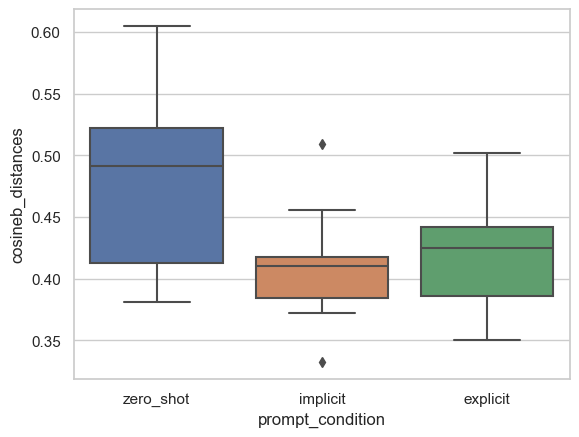

In [145]:
sns.boxplot(y='cosineb_distances', x='prompt_condition', data=res)

In [167]:
import numpy as np
from scipy import stats

def perm_test(df, prompt_con, dv):
    """
    Permutation test: One-tailed hypothesis that the zero shot condition has higher distance than another condition 
    """
    zero_shot = df[df['prompt_condition'] == 'zero_shot'][dv].values
    other = df[df['prompt_condition'] == prompt_con][dv].values

    def mean_diff(zero_shot, other):
        return np.mean(zero_shot) - np.mean(other)
    
    observed_stat = mean_diff(zero_shot, other)
    p_value = stats.permutation_test((zero_shot, other), statistic=mean_diff, alternative='greater').pvalue
    
    return p_value, observed_stat

ps = []
for prompt in ['implicit', 'explicit']:
    for dv in ['cosineb_distances', 'pos_distances', 'length_distances', 'readability_distances']:
        p, obs = perm_test(res, prompt, dv)
        row = {'prompt':prompt, 'dv':dv, 'p':p, 'obs_diff':obs}
        ps.append(row)

In [168]:
ps

[{'prompt': 'implicit',
  'dv': 'cosineb_distances',
  'p': 0.0046,
  'obs_diff': 0.07031764190954465},
 {'prompt': 'implicit',
  'dv': 'pos_distances',
  'p': 0.5085,
  'obs_diff': -0.0004644463789655884},
 {'prompt': 'implicit',
  'dv': 'length_distances',
  'p': 1.0,
  'obs_diff': -91.54166666666667},
 {'prompt': 'implicit',
  'dv': 'readability_distances',
  'p': 0.7684,
  'obs_diff': -8.013750000000002},
 {'prompt': 'explicit',
  'dv': 'cosineb_distances',
  'p': 0.0141,
  'obs_diff': 0.05788561352528632},
 {'prompt': 'explicit',
  'dv': 'pos_distances',
  'p': 0.3603,
  'obs_diff': 0.02650635369597032},
 {'prompt': 'explicit',
  'dv': 'length_distances',
  'p': 1.0,
  'obs_diff': -74.54166666666667},
 {'prompt': 'explicit',
  'dv': 'readability_distances',
  'p': 0.4371,
  'obs_diff': 1.6610416666666667}]

In [118]:
row = res.iloc[0]

outputs = row['output_embeddings']
examples = row['example_embeddings']
distances = []
for o_embedding in outputs:
    for e_embedding in examples:
        distance = cosine(list(o_embedding),list(e_embedding))
        distances.append(distance)
        
np.mean(distances)

0.8629059250233695

In [117]:
row

prompt_condition                                                 zero_shot
trial_no                                                                 0
idx                                                                      0
examples                 [small chair, BREAK A NUT, BUILD, A way to fil...
output_responses         \n\n1. Use a brick as the base of a DIY outdoo...
n_examples                                                               4
temperature                                                            0.6
frequency_penalty                                                      1.0
presence_penalty                                                       1.0
output                   [use a brick as the base of a diy outdoor fire...
output_embeddings        [[-0.08925961, 0.12767501, -0.02408735, -0.192...
example_embeddings       [[0.01571571, 0.06764027, 0.36385265, 0.207308...
output_pos_dists         {'VB': 0.04938271604938271, 'DT': 0.0987654320...
example_pos_dists        

# Analysis

## By Prompt

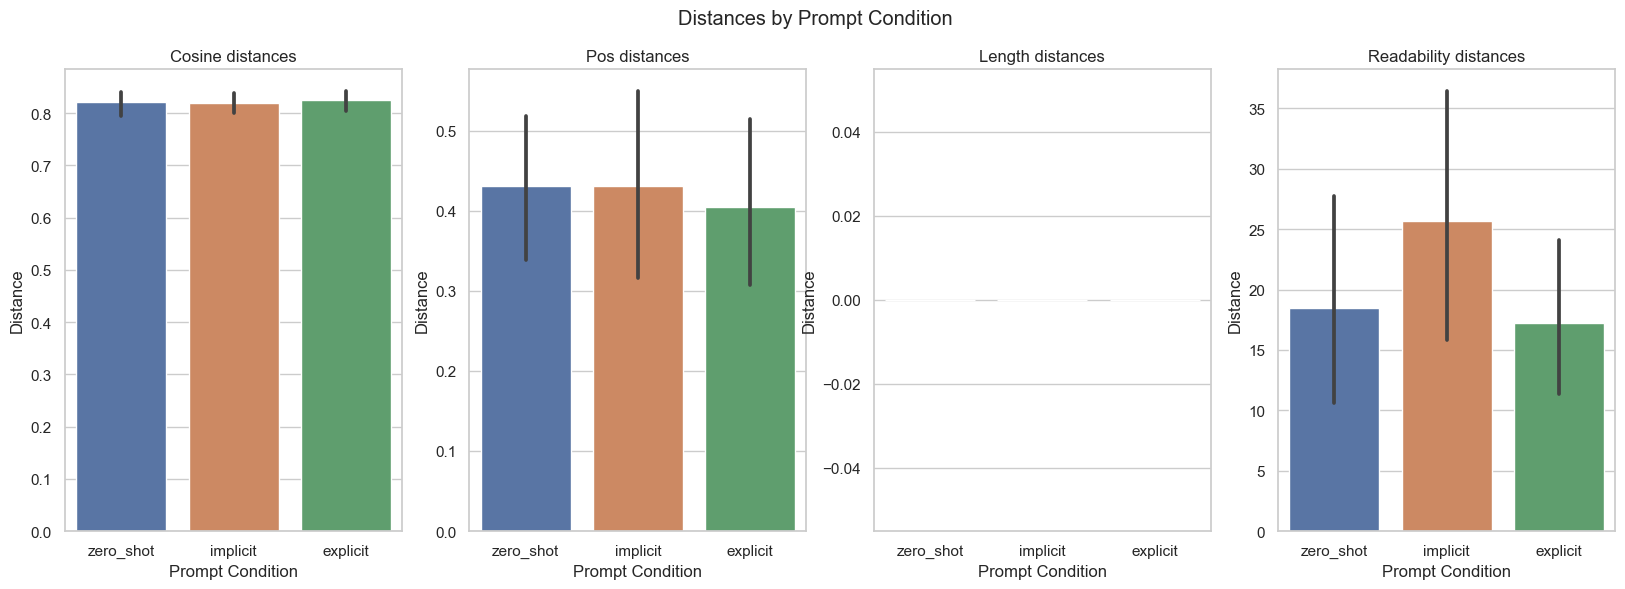

In [120]:
import seaborn as sns


# Set the style of the plot
sns.set(style="whitegrid")

# Create a new DataFrame with distances and prompt conditions
distance_df = res[['prompt_condition', 'cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']]

# Melt the distance columns into a single column for seaborn
melted_distance_df = distance_df.melt(id_vars=['prompt_condition'], var_name='distance_metric', value_name='distance')

# Define the distance metrics
distance_metrics = ['cosine_distances', 'pos_distances', 'length_distances', 'readability_distances']

# Create the grid plot
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=False)
fig.suptitle('Distances by Prompt Condition')

for ax, metric in zip(axes, distance_metrics):
    sns.barplot(x='prompt_condition', y='distance', data=melted_distance_df[melted_distance_df['distance_metric'] == metric],  ax=ax)
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_xlabel('Prompt Condition')
    ax.set_ylabel('Distance')

plt.show()


In [64]:
melted_distance_df

,prompt_condition,distance_metric,distance
0,zero_shot,cosine_distances,0.050959
1,implicit,cosine_distances,0.301178
2,explicit,cosine_distances,0.048931
3,zero_shot,cosine_distances,0.090614
4,implicit,cosine_distances,0.218297
...,...,...,...
139,implicit,readability_distances,20.477500
140,explicit,readability_distances,5.502500
141,zero_shot,readability_distances,21.020000
142,implicit,readability_distances,35.197500


In [9]:
def semantic_embedding(texts, model):
    embeddings = []
    for text in texts:
        ideas = text.split()
        idea_embeddings = model.encode(ideas)
        mean_embedding = np.mean(idea_embeddings, axis=0)
        embeddings.append(mean_embedding)
    return embeddings

texts = ["There is a cat", "There is a hat"]
semantic_embedding(texts, sentence_model)[0].shape

(768,)

In [13]:
res['output_embeddings'] = semantic_embedding(res['output'].apply(' '.join), sentence_model)
res['example_embeddings'] = semantic_embedding(res['examples'].apply(' '.join), sentence_model)

In [44]:
o1 = res['output_embeddings'].tolist()[0]
e1 = res['example_embeddings'].tolist()[0]

In [49]:
cosine_similarity([o1, e1])[0][0]

1.0

In [75]:
row = res.iloc[0]

outputs = row['output_embeddings']



In [80]:
outputs.shape

(73, 768)

In [78]:
row['output']

['use a brick as the base of a diy outdoor fire pit.',
 'make creative stepping stones with colorful paint and patterned designs on bricks for your backyard walkway or flower bed path.',
 'place several bricks in an outdoor area to create your own “mini golf” course for some family fun!',
 'create an interesting garden planter by using a brick as the bottom layer and adding soil, plants, and other decorative elements on top.']